# Pareto Hybrids w Asymmetric Tails #

The Phat distribution is a two-tailed, fully-continuous, well-defined asymmetric power law probability distribution.

The **phat** package makes available several methods to fit a given time-series dataset to the parameters of the Phat distribution and produce a forecast with the results.

## Installation ##

Installation available via `pip`

```console
$ pip install phat-tails
```

### Dependencies ###

+ Python verisons: 3.9
+ Scipy 1.7.*
+ Scikit-learn 0.24.*
+ Tensorflow 2.5.*
+ Numba 0.53.*

Also see requirements and compatibility specifications for [Tensorflow](https://www.tensorflow.org/install) and [Numba](https://numba.readthedocs.io/en/stable/user/installing.html)

### Suggested ###
+ [arch](https://arch.readthedocs.io/en/latest/): *the* python package for fitting and forecasting GARCH models
+ [pmdarima](http://alkaline-ml.com/pmdarima/): recommend for fitting ARMA models (`arch` currently does not support MA)
+ [statsmodels](https://www.statsmodels.org/): wrapped by both `arch` and `pmdarima` and used in the `fit` method of the `Phat` model.
+ [tensorboard](https://www.tensorflow.org/tensorboard/get_started): monitoring tool for tensorflow
+ [yfinance](https://github.com/ranaroussi/yfinance): for downloading historical price data

### Also Check Out ###

+ [tail-estimation](https://github.com/ivanvoitalov/tail-estimation)
    + built as part of [Ivan Voitalov et al (2019)](https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.1.033034) on tail index estimation techniques for power law phenomenon in scale-free networks
    + code from this package is utilized in the `two_tailed_hill_double_bootstrap` function
+ [thresholdmodeling](https://github.com/iagolemos1/thresholdmodeling) for a package on manual Peak-over-Threshold (PoT) analysis.

## Enhancements ##

Potential enhancements under consideration:

+ truncated Pareto tails
+ additional tail index estimation techniques
+ integration with Heston or other stochastic volatility models
+ incorporation of Phat innovations into `fit` of AR-GARCH or ARMA-GARCH via custom model
+ generalization to additional GARCH models
+ better optimization of `Garchcaster.forecast` method
+ simplify `Garchcaster` interface

## The Issue with Fat Tails ##

Many phenomena are understood to exhibit fat tails: insurance losses, wealth distribution, [rainfall](https://hess.copernicus.org/articles/17/851/2013/hess-17-851-2013.pdf), etc. These are one-tailed phenomenom (usually bounded by zero) for which many potential distributions are applicable: Weibull, Levy, Frechet, Paretos I-IV, the generalized Pareto, the Extreme Value distribution etc.

Unfortunately, for two-tailed phenomenon like financial asset returns, there are only two imperfect candidates:

+ Levy-Stable Distribution 
    + the Levy-Stable is bounded in the range $\alpha \in (0, 2]$ with $\alpha = 2$ being the Gaussian distribution. Thus, the Levy-Stable *only* exhibits fat tails with tail index $\alpha < 2$
    + Unfortunately, equity returns in particular are known to have both a [second moment](https://fan.princeton.edu/fan/FinEcon/chap1.pdf) AND fat tails ([see Danielsson and de Vries 1997](references.ipynb)), meaning $\alpha > 2$, which the Levy-Stable does not support.
+ Student's T
    + the Student's T is the most popular distribution for modelling asset returns as it does exhibit modest fat tails and is power law-*like*.
    + unfortunately, the Student's T only *tends* toward a power law in the extreme tails and so can still heavily underestimate extreme events.
    + also, the Student's T is symmetric and cannot accomodate different tail indices in either tail. Nor can the skewed Student's T, which is asymmetric, but accepts only a single tail index (although recently an asymmetric Student's T has [been proposed](https://www.sciencedirect.com/science/article/abs/pii/S0304407610000266)).

## the Phat Distribution ##

The Phat distribution is an attempt to address the issues of fat-tails in two-tailed data. It is a mixture model of two Pareto hybrid distributions, as described in [2009 by Julie Carreau and Yoshua Bengio](https://www.researchgate.net/publication/226293435_A_hybrid_Pareto_model_for_asymmetric_fat-tailed_data_The_univariate_case) (and dubbed by us as the "Carben" distribution). The Carben is a piece-wise combination of a single Gaussian distribution and a generalized Pareto distribution fused at the Pareto location, $a$.

The result is a distribution with Gaussian-body and distinct Pareto power laws in either tail. The distribution requires only 4 parameters:

+ $\mu, \sigma$ in the Gaussian body
+ $\xi_{\text{left}}, \xi_{\text{right}}$, being the inverse tail index for either Paretian tail.

Below, we show a Phat distribution with a standard normal body and symmetric Paretian tails with $\xi = .2$ (corresponding to $\alpha = 5$), highlighting the distributions different sections.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats as scist
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'whitegrid')

import numba as nb
import phat as ph

shape, mean, sig = 1/5, 0, 1
x = np.linspace(-5+mean, 5+mean, 1000)
phat_dist = ph.Phat(mean, sig, shape, shape)

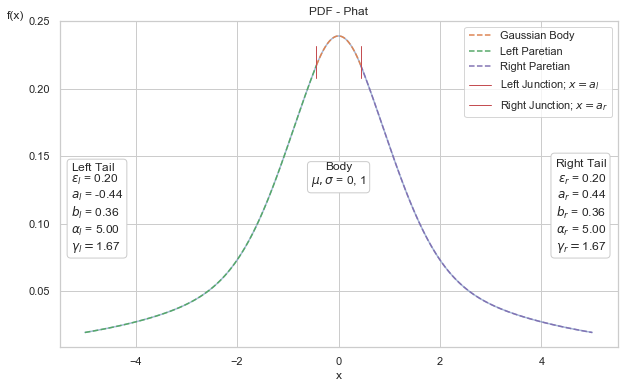

In [3]:
fig, ax1 = plt.subplots(1,1,figsize=(10,6))

ax1.plot(x, phat_dist.pdf(x), alpha=.5)
x_body = np.linspace(phat_dist.left.a, phat_dist.right.a, 100)
x_left = np.linspace(x[0], phat_dist.left.a, 100)
x_right = np.linspace(phat_dist.right.a, x[-1], 100)
ax1.plot(x_body, phat_dist.pdf(x_body), c='C1', ls='--', label='Gaussian Body')
ax1.plot(x_left, phat_dist.pdf(x_left), c='C2', ls='--', label='Left Paretian')
ax1.plot(x_right, phat_dist.pdf(x_right), c='C4', ls='--', label='Right Paretian')

ax1.axvline(
    phat_dist.left.a, .825, .925, 
    c='r', lw=1, label=r'Left Junction; $x = a_l$')
ax1.axvline(phat_dist.right.a, .825, .925, c='r', lw=1, label=r'Right Junction; $x = a_r$')

paramtxt = 'Body'
paramtxt += '\n'
paramtxt += r'$\mu, \sigma$ = ' + f'{phat_dist.mu:.0f}, {phat_dist.sig:.0f}'

ax1.text(
    .5, .5, paramtxt, ha='center',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)

paramtxt = r'Left Tail$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_{l}$ = ' + f'{phat_dist.left.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$a_l$ = ' + f'{phat_dist.left.a:.2f}'
paramtxt += '\n'
paramtxt += r'$b_l$ = ' + f'{1 / phat_dist.left.b:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_l$ = ' + f'{1 / phat_dist.left.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_l = $' + f'{phat_dist.right.gamma:.2f}'

ax1.text(
    .02,.3, paramtxt,
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)
paramtxt = r'Right Tail$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_r$ = ' + f'{phat_dist.right.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$a_r$ = ' + f'{phat_dist.right.a:.2f}'
paramtxt += '\n'
paramtxt += r'$b_r$ = ' + f'{1 / phat_dist.right.b:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_r$ = ' + f'{1 / phat_dist.right.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_r = $' + f'{phat_dist.right.gamma:.2f}'

ax1.text(
    .98,.3, paramtxt, ha='right',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)', loc='top', rotation='horizontal')

ax1.legend()
ax1.set_title('PDF - Phat')

plt.show()

The Paretian tails are parameterized independently and so allow for asymmetry. Below we show two Phat distributions, one with symmetric tail index of $\alpha=2$ and the other with asymmetric tail indices, $\alpha_{\text{left}}=2$ and $\alpha_{\text{right}}=20$.

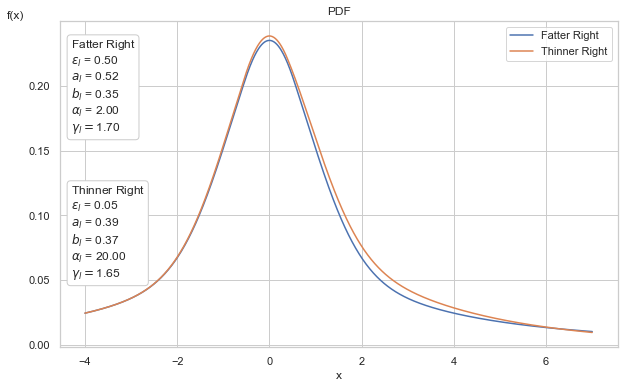

In [4]:
mean, sig = 0, 1
x = np.linspace(-4+mean, 7+mean, 1000)
shape_l1, shape_r = 1/2, 1/2
dist1 = ph.Phat(mean, sig, shape_l1, shape_r)
shape_l2, shape_r = 1/2, 1/20
dist2 = ph.Phat(mean, sig, shape_l2, shape_r,)

fig, ax1 = plt.subplots(1,1,figsize=(10,6))

ax1.plot(x, dist1.pdf(x), label='Fatter Right')
ax1.plot(x, dist2.pdf(x), label='Thinner Right')

paramtxt = r'Fatter Right$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_{l}$ = ' + f'{dist1.right.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$a_l$ = ' + f'{dist1.right.a:.2f}'
paramtxt += '\n'
paramtxt += r'$b_l$ = ' + f'{1 / dist1.right.b:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_l$ = ' + f'{1 / dist1.right.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_l = $' + f'{dist1.right.gamma:.2f}'

ax1.text(
    .02,.95, paramtxt, va='top',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)
paramtxt = r'Thinner Right$_{}$'
paramtxt += '\n'
paramtxt += r'$\epsilon_{l}$ = ' + f'{dist2.right.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$a_l$ = ' + f'{dist2.right.a:.2f}'
paramtxt += '\n'
paramtxt += r'$b_l$ = ' + f'{1 / dist2.right.b:.2f}'
paramtxt += '\n'
paramtxt += r'$\alpha_l$ = ' + f'{1 / dist2.right.xi:.2f}'
paramtxt += '\n'
paramtxt += r'$\gamma_l = $' + f'{dist2.right.gamma:.2f}'

ax1.text(
    .02,.2, paramtxt, va='bottom',
    transform=ax1.transAxes,
    bbox=dict(boxstyle='round', ec='.8', fc='w')
)
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)', loc='top', rotation='horizontal')

ax1.legend()

ax1.set_title('PDF')

plt.show()

The left tails are identical. In the right tails, the distribution with the greater tail index has a slightly lower probability in the body and a slightly higher probability out in the tails, leading to dramatically different effects.

## Demo ##

Below we show a simple process for fitting and projecting a financial time series using `phat`; this example will utilize end-of-day daily prices of Coca-Cola, for which there is data back to 1962.

the Fit:

+ download the daily prices of Coca-Cola (ticker: KO). Find the daily returns in percentage terms (i.e. x 100).
+ use the `arch` package to fit a GARCH(1,1) model to the daily returns
+ use the Hill double bootstrap method to estimate the tail index of both tails of the standardized residuals of the AR-GARCH fit.
+ use `phat` custom data class, `DataSplit`, to split the data into training, testing, and validation subsets. *Be careful to scale by 1/10.*
+ use `PhatNet` and `phat`'s custom loss function `PhatLoss` to fit the remaining parameters.
+ use `Garchcaster` to produce 10,000 simulations of a one-year forecast via the same AR-GARCH model.

In [5]:
import yfinance as yf
import arch

ko = yf.download('KO')
ko_ret = ko.Close.pct_change().dropna()*100
ko_ret = ko_ret[-252*10:]

[*********************100%***********************]  1 of 1 completed


In [6]:
res = arch.arch_model(ko_ret, mean='Constant', vol='Garch', p=1, q=1).fit(disp='off')
xi_left, xi_right = ph.two_tailed_hill_double_bootstrap(res.std_resid)

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
data = ph.DataSplit(res.std_resid[2:]/10)
pnet = ph.PhatNet(neurons=1)
pnet.compile(
    loss = ph.PhatLoss(xi_left,xi_right), 
    optimizer = 'adam'
)
history = pnet.fit(data.train, validation_data=data.test, epochs=100, verbose=0)

2022-01-09 11:46:00.403376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-09 11:46:02.860740: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 00085: early stopping


The training process above results in the following estimated parameters for the standardized GARCH residuals.

In [8]:
pnet.predicted_params()

,
mean,0.006816
sig,0.034761
shape_l,0.347018
shape_r,0.284443


Below we compare the fit of the Phat distribution to that of the Guassian and the Student's T. Note the Student's T fits to $v=4.65$, which is equivalent to $\xi = 0.22$, which is a thinner tail than found through the Hill Double bootstrap, particularly for the left tail.

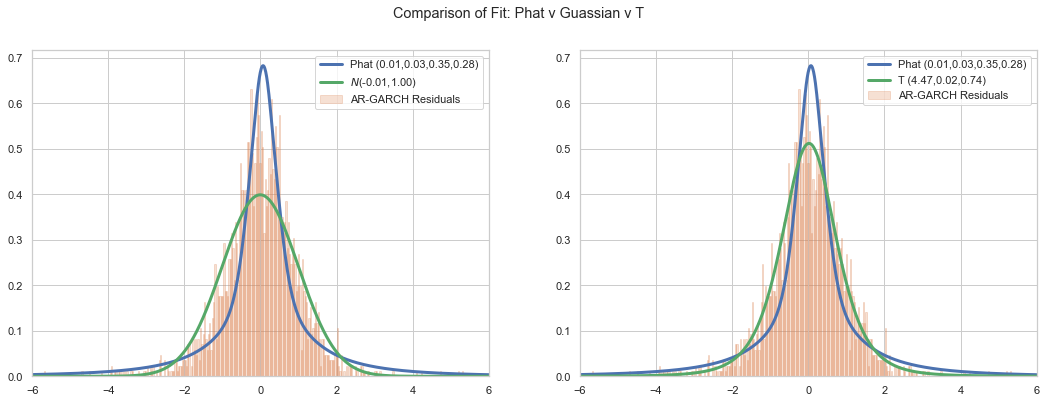

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
mu, sig, l, r = pnet.predicted_params().values.flatten()
phatdist = ph.Phat(mu*10, sig*10, l, r)

x = np.linspace(-6,6,1000)
counts, bins, _ = ax1.hist(
    data.raw.y*10, bins=500, density=True, fc='C1', ec='C1', alpha=.25,
    label='AR-GARCH Residuals'
)
ax1.plot(x, phatdist.pdf(x), lw=3, c='C0', label=f'Phat ({mu:.2f},{sig:.2f},{l:.2f},{r:.2f})')

norm_params = scist.norm.fit(data.raw.y*10)
norm_label = ','.join([f'{p:.2f}' for p in norm_params])
ax1.plot(x, scist.norm(*norm_params).pdf(x), c='C2', lw=3, label=r'$N$' f'({norm_label})')
ax1.set_xlim(-6, 6)

counts, bins, _ = ax2.hist(
    data.raw.y*10, bins=500, density=True, fc='C1', ec='C1', alpha=.25,
    label='AR-GARCH Residuals'    
)
ax2.plot(x, phatdist.pdf(x), lw=3, c='C0', label=f'Phat ({mu:.2f},{sig:.2f},{l:.2f},{r:.2f})')

t_params = scist.t.fit(data.raw.y*10)
t_label = ','.join([f'{p:.2f}' for name, p in zip([r'$v$', 'loc', 'scale'], t_params)])
ax2.plot(x, scist.t(*t_params).pdf(x), c='C2', lw=3, label=f'T ({t_label})')
ax2.set_xlim(-6, 6)

ax1.legend()
ax2.legend()

plt.suptitle('Comparison of Fit: Phat v Guassian v T')

plt.show()

The Phat distribution is a better fit to the peak of the distribution while both the Gaussian and Student's T are better fits in the shoulders. The devil, of course, is in the tails.

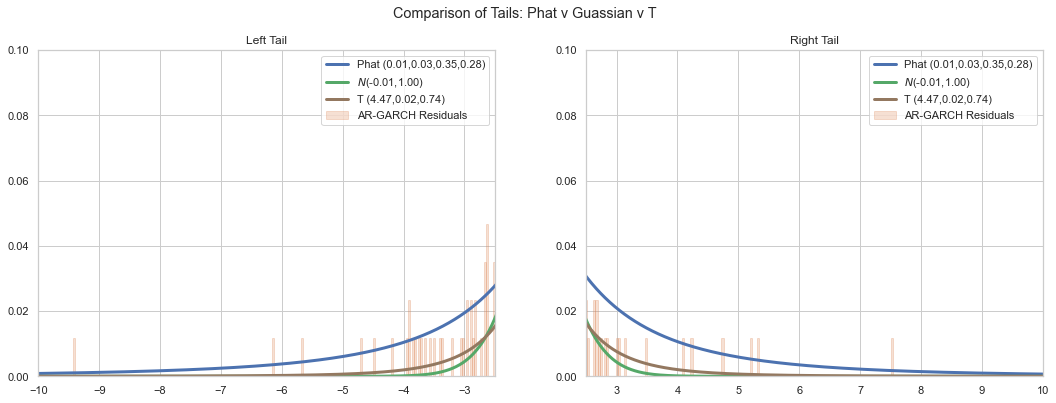

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
mu, sig, l, r = pnet.predicted_params().values.flatten()
phatdist = ph.Phat(mu*10, sig*10, l, r)

x = np.linspace(-10,-2,1000)
counts, bins, _ = ax1.hist(
    data.raw.y*10, bins=500, density=True, fc='C1', ec='C1', alpha=.25,
    label='AR-GARCH Residuals'
)
ax1.plot(x, phatdist.pdf(x), lw=3, c='C0', label=f'Phat ({mu:.2f},{sig:.2f},{l:.2f},{r:.2f})')

norm_params = scist.norm.fit(data.raw.y*10)
norm_label = ','.join([f'{p:.2f}' for p in norm_params])
t_params = scist.t.fit(data.raw.y*10)
t_label = ','.join([f'{p:.2f}' for name, p in zip([r'$v$', 'loc', 'scale'], t_params)])

ax1.plot(x, scist.norm(*norm_params).pdf(x), c='C2', lw=3, label=r'$N$' f'({norm_label})')
ax1.plot(x, scist.t(*t_params).pdf(x), c='C5', lw=3, label=f'T ({t_label})')
ax1.set_xlim(-10,-2.5)
ax1.set_ylim(0,.1)

x = np.linspace(2,10,1000)
counts, bins, _ = ax2.hist(
    data.raw.y*10, bins=500, density=True, fc='C1', ec='C1', alpha=.25,
    label='AR-GARCH Residuals'    
)
ax2.plot(x, phatdist.pdf(x), lw=3, c='C0', label=f'Phat ({mu:.2f},{sig:.2f},{l:.2f},{r:.2f})')
ax2.plot(x, scist.norm(*norm_params).pdf(x), c='C2', lw=3, label=r'$N$' f'({norm_label})')
ax2.plot(x, scist.t(*t_params).pdf(x), c='C5', lw=3, label=f'T ({t_label})')
ax2.set_xlim(2.5,10)
ax2.set_ylim(0,.1)

ax1.legend()
ax2.legend()
ax1.set_title('Left Tail')
ax2.set_title('Right Tail')

plt.suptitle('Comparison of Tails: Phat v Guassian v T')

plt.show()

Out in the left and right tails we see the Phat distribution is much better at capturing extreme events that have occured in the past 10 years.

We can then feed this distribution, along with the results from the AR-GARCH fit, into the `Garchcaster`.

In [11]:
n = 10000
days = 252

mu, sig, l, r = pnet.predicted_params().values
phatdist = ph.Phat(mu*10, sig*10, l, r)
fore = ph.Garchcaster(
    garch=res,
    iters=n,
    periods=days,
    order=(0,0,1,1),
    dist=phatdist
).forecast()

Calling the `forecast` method results in 10,000 separate AR-GARCH simulations, each spanning 252 trading days. A `GarchcastResults` container is returned, which includes some plotting methods for convenience.

We can see the conditional variance of the resulting forecasts.

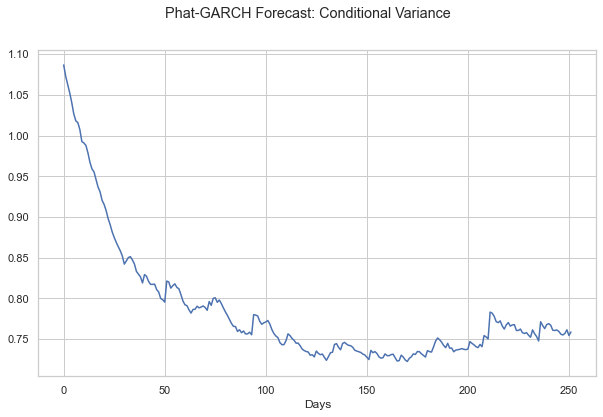

In [12]:
fore.plot('var')
plt.show()

We can plot individual simulations.

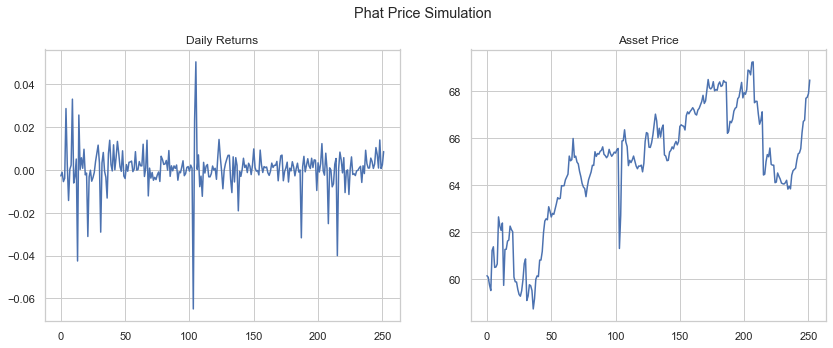

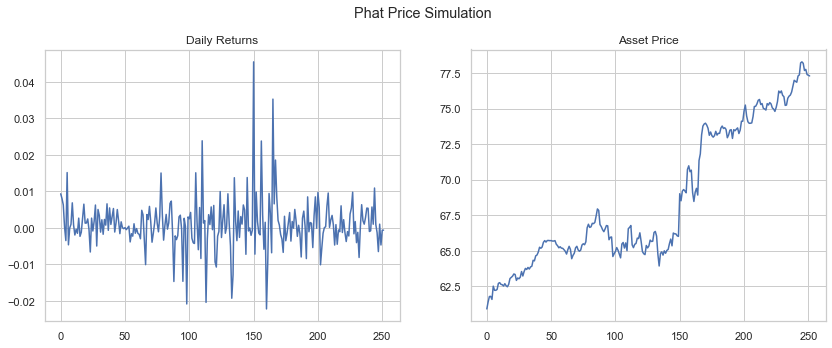

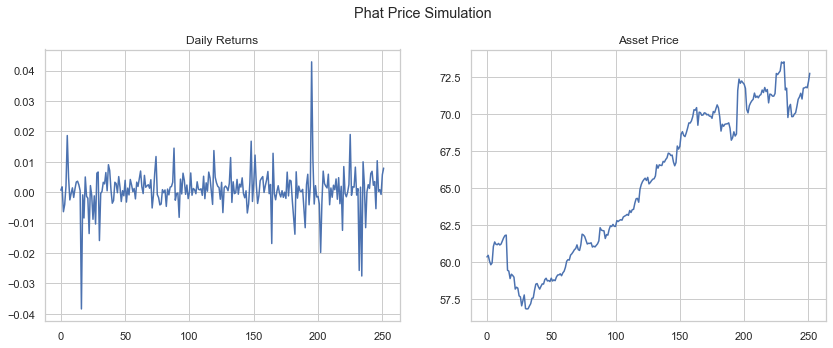

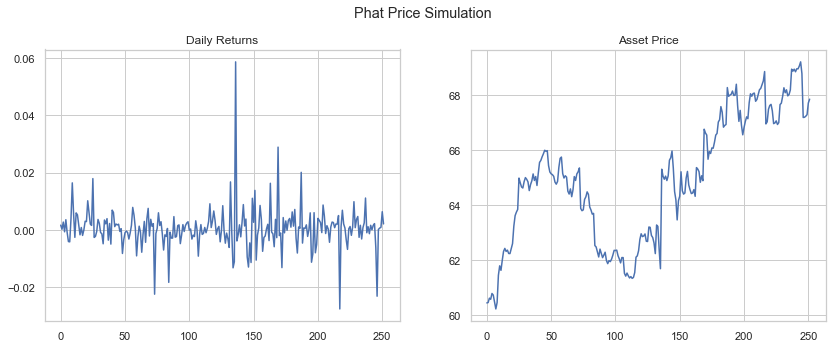

In [13]:
fore.plot('price', p=ko.Close[-1], n=4)
plt.show()

And we can plot a histogram of the final price in each simulation.

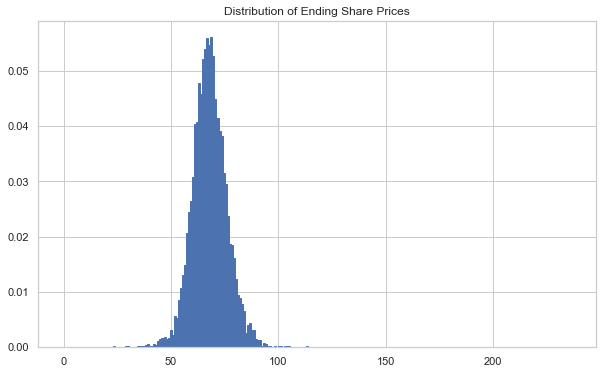

In [14]:
ax, P, bins = fore.plot('end_price', p=ko.Close[-1], ec='C0')
plt.show()